# HW3 - Group3

- Akshat Johari
- Harsh Mehta
- Vivek Mehendiratta

## To get better understanding of data, **duplicates are removed** from `gold` and `labels` data

# Import Libraries

In [1]:
import pandas as pd
import seaborn as sns

## [Q1 10 points] Read in data

Read in the files gold.txt and labels.txt. The gold DataFrame should have columns url and category, while the labels DataFrame should have columns turk, url and category. You will have to pick the right separator.

In [2]:
gold = pd.read_csv("gold.txt", delimiter='\t', header=None, names=['url', 'category'])
labels = pd.read_csv("labels.txt", delimiter='\t', header=None, names=['turk', 'url', 'category'])

# Removing duplicates
labels.drop_duplicates(inplace = True)

gold.shape, labels.shape

((1517, 2), (89948, 3))

In [3]:
len(labels["url"].unique())

11040

## [Q2 10 points] Split into two DataFrames

Split the labels DataFrame into two: labels on gold and labels unknown, the former containing all rows where the url is present in the gold set, and the latter one contains all remaining rows of labels.

In [4]:
labels_on_gold = labels.merge(gold, on = 'url', how = 'inner', suffixes=["_label", "_gold"])
labels_on_gold.shape

(3319, 4)

In [5]:
labels_unknown = labels[~labels["url"].isin(labels_on_gold["url"])]
labels_unknown.shape

(86629, 3)

## [Q3 10 points] Compute accuracies of turks
Create a rater goodness DataFrame that is indexed by turk, and has two columns: the number of ratings, and the average correctness of ratings for each turk (both on gold set urls).

In [6]:
labels_on_gold["correct"] = labels_on_gold.apply(lambda x : 1 if x["category_gold"] == x["category_label"] else 0, axis = 1)

In [7]:
labels_on_gold.columns

Index(['turk', 'url', 'category_label', 'category_gold', 'correct'], dtype='object')

In [8]:
rater_goodness = labels_on_gold.groupby("turk").agg({'correct':['count', 'mean']}).droplevel(0, axis = 1)

rater_goodness.columns = ['number_of_ratings', 'average_correctness']

rater_goodness.sort_values(by='number_of_ratings', ascending=False).head(10)

,number_of_ratings,average_correctness
turk,,
A31OCN4MNHUQ6W,184,0.777174
A153PKAL7OAY36,148,0.722973
A2BTR0GQ5B5JI6,126,0.523810
ATVALOQVDCMZW,103,0.854369
AZSDW7JJL5VA7,100,0.680000
A3GE97GX3OXJTW,85,0.658824
A3JMQDTEKRE5X6,80,0.675000
A2JP3HEL3J25AJ,80,0.687500
A3MA9V9UPGCOK7,71,0.774648


In [9]:
rater_goodness.shape

(269, 2)

## [Q4 10 points] Odds ratios
If someone is correct p fraction of the time, the odds of success are defined as:
odds = p/(1.001 − p).

Attach a column called odds to the rater goodness DataFrame, using the average correctness of the turk as his or her p.


In [10]:
rater_goodness["odds"] = rater_goodness["average_correctness"].apply(lambda x : x / (1.001 - x))

In [11]:
rater_goodness.sort_values(by='number_of_ratings', ascending = False).head()

,number_of_ratings,average_correctness,odds
turk,,,
A31OCN4MNHUQ6W,184,0.777174,3.472222
A153PKAL7OAY36,148,0.722973,2.600369
A2BTR0GQ5B5JI6,126,0.523810,1.097695
ATVALOQVDCMZW,103,0.854369,5.826657
AZSDW7JJL5VA7,100,0.680000,2.118380


## [Q5 10 points] Most accurate turks
List the top 10 most accurate turks who have rated at least 20 gold set URLs.

In [12]:
rater_goodness[rater_goodness["number_of_ratings"] >=20].sort_values(by = "average_correctness", ascending = False).head(10)

,number_of_ratings,average_correctness,odds
turk,,,
A2U0R4X38GUKZE,20,0.950000,18.627451
A22C0PJUBFJTI0,36,0.916667,10.869565
A23YQUBXZPKILZ,24,0.875000,6.944444
ATVALOQVDCMZW,103,0.854369,5.826657
A1HIXWH4OXT8S4,40,0.825000,4.687500
A3220HG1O83HQ4,22,0.818182,4.475385
A32W20KGQXS0LL,25,0.800000,3.980100
A20PWAB7G3HDHU,20,0.800000,3.980100
AJSJVK40F5HM6,28,0.785714,3.649635


In [13]:
rater_goodness[rater_goodness["number_of_ratings"] >=20].sort_values(by = "average_correctness", ascending = False)[:10].index.values.tolist()

['A2U0R4X38GUKZE',
 'A22C0PJUBFJTI0',
 'A23YQUBXZPKILZ',
 'ATVALOQVDCMZW',
 'A1HIXWH4OXT8S4',
 'A3220HG1O83HQ4',
 'A32W20KGQXS0LL',
 'A20PWAB7G3HDHU',
 'AJSJVK40F5HM6',
 'A31OCN4MNHUQ6W']

## [Q6 10 points] Rating counts versus accuracy

One may imagine that a committed and accurate turk will rate lots of URLs. On the other hand, perhaps it is only the spammers who have the time to rate lots of URLs.
 
Is number of ratings by a turker on gold set URLs related to his or her accuracy? There’s no fixed answer; just try to show some evidence for your answer.

<AxesSubplot:xlabel='number_of_ratings', ylabel='average_correctness'>

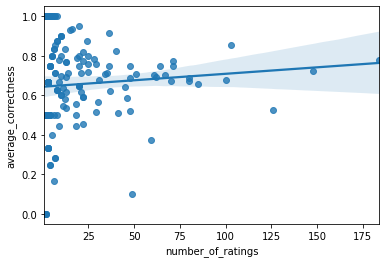

In [14]:
sns.regplot(x="number_of_ratings", y="average_correctness", data=rater_goodness)

#### There is some upward trend. Let's check the correlation score between 2 scaled variables.

In [15]:
rater_goodness["average_correctness"].corr(rater_goodness["number_of_ratings"])

0.044982640441412765

#### No correlation

There seems to be outliers in the data, specially `number_of_ratings`. Let's deep dive and remove outliers and find correlation

In [16]:
# function to remove outliers and subset the dataframe
def subset_by_iqr(df, column, whisker_width=1.5):
    """Remove outliers from a dataframe by column, including optional 
       whiskers, removing rows for which the column value are 
       less than Q1-1.5IQR or greater than Q3+1.5IQR.
    Args:
        df (`:obj:pd.DataFrame`): A pandas dataframe to subset
        column (str): Name of the column to calculate the subset from.
        whisker_width (float): Optional, loosen the IQR filter by a
                               factor of `whisker_width` * IQR.
    Returns:
        (`:obj:pd.DataFrame`): Filtered dataframe
    """
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]                                                     

# Example for whiskers = 1.5, as requested by the OP
df_filtered = subset_by_iqr(rater_goodness, 'number_of_ratings', whisker_width=1.5)
df_filtered = subset_by_iqr(df_filtered, 'average_correctness', whisker_width=1.5)

In [17]:
df_filtered.head()

,number_of_ratings,average_correctness,odds
turk,,,
A112DVP1KG4QZU,1,1.000000,1000.000000
A12CY1Q7XKJJDE,1,1.000000,1000.000000
A12RE8G66WTO8B,20,0.750000,2.988048
A12Y1GTGIQDGRA,3,0.333333,0.499251
A13CEW9JGDWGX1,1,1.000000,1000.000000


<AxesSubplot:xlabel='number_of_ratings', ylabel='average_correctness'>

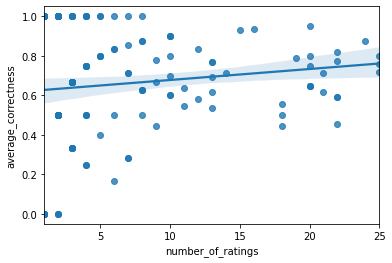

In [18]:
sns.regplot(x="number_of_ratings", y="average_correctness", data=df_filtered)

In [19]:
df_filtered["average_correctness"].corr(df_filtered["number_of_ratings"])

0.09247660565222936

There doesn't seem to be any correlation between `average_correctness` and `number_ofratings`

## [Q7 13 points] Overall predicted odds

Consider each url u that is not in the gold set, and each category c. For the pair (u, c), calculate the product of odds of all turks who 
(a) rated url u as category c, and 
(b) have rated more gold set urls than 75% of all turks who rated at least one gold-set url.

For example, if you find that there are 269 turks who rated at least one gold-set url, you want to select only the turks who have rated more gold-set urls than 75% of these 269 turks. We can think of these as our “reliable” turks. Now, our belief that url u belongs to category c depends on how many “reliable” turks rated u as c; specifically, our belief is based on the product of their reliability scores (i.e., their odds).

We shall call such products of odds the overall odds henceforth.

In [20]:
rater_goodness["number_of_ratings"].quantile(0.75)

11.0

In [21]:
mark_75 = rater_goodness["number_of_ratings"].quantile(0.75)
top25_turks = rater_goodness[rater_goodness["number_of_ratings"] > mark_75].index.values
len(top25_turks)

66

In [22]:
labels_unknown_reliable = labels_unknown[labels_unknown["turk"].isin(top25_turks)]

In [23]:
labels_unknown_reliable

,turk,url,category
1,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
10,A1PXXEOGQ76RNJ,http://0000.jp,G
11,A1XFA0A9Z3LAZJ,http://0000.jp,G
12,A21US576U8SCO4,http://0000.jp,G
...,...,...,...
92707,A4GP97LAQCCHJ,http://zynga.com,G
92709,A1PXXEOGQ76RNJ,http://zz868.com,G
92715,A4AD9ZMVU9SVA,http://zz868.com,P
92719,A21US576U8SCO4,http://zzx.cc,G


In [24]:
rater_goodness

,number_of_ratings,average_correctness,odds
turk,,,
A112DVP1KG4QZU,1,1.000000,1000.000000
A1253FXHCZ9CWM,29,0.517241,1.069214
A12CY1Q7XKJJDE,1,1.000000,1000.000000
A12RE8G66WTO8B,20,0.750000,2.988048
A12Y1GTGIQDGRA,3,0.333333,0.499251
...,...,...,...
AYWOBMTEGFVVI,1,0.000000,0.000000
AZ1S5BIG5R6P6,35,0.714286,2.491281
AZSDW7JJL5VA7,100,0.680000,2.118380


In [25]:
labels_unknown_reliable.shape

(37998, 3)

In [26]:
labels_unknown_reliable = labels_unknown_reliable.merge(rater_goodness[['odds']], right_index=True, left_on = 'turk')

In [27]:
labels_unknown_reliable

,turk,url,category,odds
1,A1PXXEOGQ76RNJ,http://000.cc,G,1.047852
10,A1PXXEOGQ76RNJ,http://0000.jp,G,1.047852
22,A1PXXEOGQ76RNJ,http://000relationships.com,G,1.047852
73,A1PXXEOGQ76RNJ,http://007swz.cn,G,1.047852
80,A1PXXEOGQ76RNJ,http://01768.com,G,1.047852
...,...,...,...,...
90172,amurray,http://www.blazzpage.7p.com/,G,13.793103
90173,amurray,http://www.byroncrawford.com/,P,13.793103
90188,amurray,http://www.freelayouticons.com/,P,13.793103
90189,amurray,http://www.hollywoodtuna.com/?p=4729,R,13.793103


In [28]:
unknown_urls_odds = labels_unknown_reliable.groupby(['url', 'category'], as_index=False).agg(overall_odds = ('odds', 'prod'))
unknown_urls_odds

,url,category,overall_odds
0,http://0-101.net,G,2.297602
1,http://000.cc,G,1.485456
2,http://0000.jp,G,14.339248
3,http://000relationships.com,G,3.841962
4,http://000relationships.com,P,1.851852
...,...,...,...
13978,http://zynga.com,G,3.666513
13979,http://zz868.com,G,1.047852
13980,http://zz868.com,P,1.851852
13981,http://zzx.cc,G,1.417620


In [29]:
labels_unknown_reliable_odds = labels_unknown_reliable.merge(unknown_urls_odds, on=['url', 'category'])
labels_unknown_reliable_odds

,turk,url,category,odds,overall_odds
0,A1PXXEOGQ76RNJ,http://000.cc,G,1.047852,1.485456
1,A21US576U8SCO4,http://000.cc,G,1.417620,1.485456
2,A1PXXEOGQ76RNJ,http://0000.jp,G,1.047852,14.339248
3,A21US576U8SCO4,http://0000.jp,G,1.417620,14.339248
4,A1XFA0A9Z3LAZJ,http://0000.jp,G,3.732272,14.339248
...,...,...,...,...,...
37993,amurray,http://www.blazzpage.7p.com/,G,13.793103,13.793103
37994,amurray,http://www.byroncrawford.com/,P,13.793103,13.793103
37995,amurray,http://www.freelayouticons.com/,P,13.793103,13.793103
37996,amurray,http://www.hollywoodtuna.com/?p=4729,R,13.793103,13.793103


## [Q8 13 points] Predicted categories

Create a DataFrame (called result_75, whose index is URLs not in the gold set, and with two columns called top category and top odds. The top category should be the category with the highest overall odds for that url, and the
top odds should be the overall odds for that top category.

These are our predictions, and the confidence we have in them (higher overall odds implies greater confidence). If you want, you can check to see if the predicted categories make sense.

In [30]:
a = pd.pivot_table(labels_unknown_reliable_odds, values='overall_odds', index = 'category', columns='url')

In [31]:
result_75 = pd.concat([a.max().rename('top_odds'), a.idxmax().rename('top_category')], axis = 1)
result_75.head()

,top_odds,top_category
url,,
http://0-101.net,2.297602,G
http://000.cc,1.485456,G
http://0000.jp,14.339248,G
http://000relationships.com,3.841962,G
http://000vitamins.com,4.033641,G


In [32]:
result_75

,top_odds,top_category
url,,
http://0-101.net,2.297602,G
http://000.cc,1.485456,G
http://0000.jp,14.339248,G
http://000relationships.com,3.841962,G
http://000vitamins.com,4.033641,G
...,...,...
http://zwinky.com,17.201875,G
http://zylom.com,1.849543,G
http://zynga.com,3.666513,G


## [Q9 14 points] Predicted categories using more turks

Questions 7 and 8 above only considered the ratings of turks who had rated enough gold set URLs, so we were relatively more confident about their accuracies. What happens if we loosen this restriction?

Repeat the code of Q7 and Q8, but replacing 75% by 25% in the description of Q7 (i.e., we also consider turks who have far fewer gold set ratings). Call this result 25. Now let’s see how these two results compare. Create a DataFrame where both the index and the columns are the various categories, and the cells
contain the number of urls with these as the top categories according to
result 75 and result 25.

For example, the cell corresponding to the row category=R and the column category=G would be the number of URLs
that were predicted to be R by result 75 but predicted to be G by result 25.
Where are the most errors ?

In [33]:
mark_25 = rater_goodness["number_of_ratings"].quantile(0.25)
top75_turks = rater_goodness[rater_goodness["number_of_ratings"] > mark_25].index.values
print(len(top75_turks))

labels_unknown_above25 = labels_unknown[labels_unknown["turk"].isin(top75_turks)]

labels_unknown_above25 = labels_unknown_above25.merge(rater_goodness[['odds']], right_index=True, left_on = 'turk')

unknown_urls_odds = labels_unknown_above25.groupby(['url', 'category'], as_index=False).agg(overall_odds = ('odds', 'prod'))
unknown_urls_odds

labels_unknown_above25_odds = labels_unknown_above25.merge(unknown_urls_odds, on=['url', 'category'])
labels_unknown_above25_odds

a = pd.pivot_table(labels_unknown_above25_odds, values='overall_odds', index = 'category', columns='url')

result_25 = pd.concat([a.max().rename('top_odds'), a.idxmax().rename('top_category')], axis = 1)
result_25.head()

173


,top_odds,top_category
url,,
http://0-101.net,2.297602e+00,G
http://000.cc,2.218192e+03,G
http://0000.jp,2.847963e+07,G
http://000relationships.com,1.851852e+00,P
http://000vitamins.com,5.343559e+00,G


In [34]:
a = result_75.merge(result_25, right_index=True, left_index=True, suffixes=["_reliable", '_above25'], how = 'inner') 

In [47]:
results_ct = pd.crosstab(a['top_category_reliable'], a['top_category_above25'])
results_ct

top_category_above25,G,P,R,X
top_category_reliable,,,,
G,8280,586,180,214
P,196,352,52,25
R,22,34,127,25
X,28,5,28,456


In [36]:
accuracy = (results_ct.iloc[0,0] + results_ct.iloc[1,1] + results_ct.iloc[2,2] + results_ct.iloc[3,3]) / results_ct.iloc[4,4]
print(accuracy)
error = (1 - accuracy) * 100
error

0.8685202639019792


13.147973609802078

Misclassification error : 13.147%

In [49]:
a = results_ct.div(results_ct.sum(axis = 1), axis = 0) * 100
a

top_category_above25,G,P,R,X
top_category_reliable,,,,
G,89.416847,6.328294,1.943844,2.311015
P,31.360000,56.320000,8.320000,4.000000
R,10.576923,16.346154,61.057692,12.019231
X,5.415861,0.967118,5.415861,88.201161


Class with most errors : `category P`